In [ ]:
import earthaccess
import os
import xarray as xr
import numpy as np
from io import BytesIO
import tempfile
#from pyhdf.SD import SD, SDC
from pyhdf.SD import *
import re
from pyproj import Transformer
import matplotlib.pyplot as plt
import rasterio
from rasterio.coords import BoundingBox

import warnings
warnings.simplefilter("ignore")

/Users/sarategoni/Documents/tesi_rifugi/alpinehutsustainability/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
## After creating an account at Nasa EarthData, I used this script for creating ~/.netrc login file
## Credits: https://cheginit.github.io/til/web_service/netrc.html 
from netrc import netrc
from typing import Dict
from getpass import getpass
from pathlib import Path

def setup_urs_login(urs: str) -> None:
    prompts = {
        "login": "\n".join(
            [
                "Enter NASA EarthData Login Username",
                f"(or create an account at {urs}): ",
            ]
        ),
        "password": "Enter NASA EarthData Login Password: ",
    }

    netrc_file = Path.home().joinpath(".netrc")

    try:
        netrc(netrc_file).authenticators(urs)[1]
    except (FileNotFoundError, TypeError) as exc:
        user_data = {p: getpass(prompt=msg) for p, msg in prompts.items()}

        fmode = "w" if exc.__class__ == FileNotFoundError else "a"
        with open(netrc_file, fmode) as f:
            msg = f"machine {urs}\n"
            msg += "\n".join(f"{p} {m}" for p, m in user_data.items())
            f.write(msg)
    print(f"User-pass info successfully set for {urs}.")

setup_urs_login("https://urs.earthdata.nasa.gov")

In [42]:
## Convert dem_bounds bbox (UTM) to EPSG:4326 (WGS84) for MODIS data request
## Had to enlarge the bbox to avoid distortions with reprojection in later analysis
DEM_PATH = '../data/terrain/tinitaly_dem500m.tif'
with rasterio.open(DEM_PATH) as src:
    dem_bounds = src.bounds  # (left, bottom, right, top)
    dem_crs = src.crs

# Expand the bounding box
buffer = 10000  # 10
expanded_bbox_utm = BoundingBox(
    left=dem_bounds.left - buffer,
    bottom=dem_bounds.bottom - buffer,
    right=dem_bounds.right + buffer,
    top=dem_bounds.top + buffer
)

# Transform the coordinates of the bounding box
transformer = Transformer.from_crs(dem_crs, "EPSG:4326", always_xy=True) 
left, bottom = transformer.transform(expanded_bbox_utm.left, expanded_bbox_utm.bottom) # was dem_bounds
right, top = transformer.transform(expanded_bbox_utm.right, expanded_bbox_utm.top)
bbox_4326 = (left, bottom, right, top)

print(f"Bounding Box in EPSG:4326:")
print(f"Left: {left}, Bottom: {bottom}, Right: {right}, Top: {top}")


Bounding Box in EPSG:4326:
Left: 10.336952283156377, Bottom: 45.610325100439375, Right: 12.084442291314119, Top: 46.61825468246664


# Data retrieval example
Dataset: [MODIS/Terra CGF Snow Cover Daily L3 Global 500m SIN Grid, Version 61](https://nsidc.org/data/mod10a1f/versions/61)

More details about code: [earthdata quick start](https://earthaccess.readthedocs.io/en/latest/quick-start/) and [search granules](https://earthaccess.readthedocs.io/en/latest/howto/search-granules/)

In [32]:
# Step 1: login (uses credentials in .netcr file)
session = earthaccess.login()
session.authenticated

True

In [33]:
# Step 2: search for data
#bbox_4326 = (10.46750857, 45.69873184, 11.94937569, 46.53633029) # TRENTINO

results = earthaccess.search_data(
    short_name = "MOD10A1F", # dataset
    version = "61",
    #cloud_hosted = True,
    bounding_box = bbox_4326,
    temporal = ("2023-01-25", "2023-01-25"),
    count = -1 # all
)
results # list of DataGranules


[Collection: {'EntryTitle': 'MODIS/Terra CGF Snow Cover Daily L3 Global 500m SIN Grid V061'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': 13.0379032886097, 'Latitude': 39.8144150819193}, {'Longitude': 15.5723926647109, 'Latitude': 49.9989721995752}, {'Longitude': -0.00867479214978881, 'Latitude': 50.0069689864989}, {'Longitude': 0.000131401253182349, 'Latitude': 39.8197706210566}, {'Longitude': 13.0379032886097, 'Latitude': 39.8144150819193}]}}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2023-01-25T00:00:00.000Z', 'EndingDateTime': '2023-01-25T23:59:59.000Z'}}
 Size(MB): 3.21028
 Data: ['https://n5eil01u.ecs.nsidc.org/DP4/MOST/MOD10A1F.061/2023.01.25/MOD10A1F.A2023025.h18v04.061.2023027052332.hdf']]

## Step 3: download a granule

In [ ]:
# Step 3: Download
destination_dir = "../data/MODIS/"
os.makedirs(destination_dir, exist_ok=True)
files = earthaccess.download(results, destination_dir)

In [ ]:
## I use the local file to inspect structure
# files are in format HDF4, I use pyhdf which is a library specifically for those
local_file = "../data/MODIS/MOD10A1F.A2022340.h18v04.061.2022351140722.hdf"

# Open the HDF4 file using pyhdf
hdf = SD(local_file, SDC.READ)

# Get the available datasets
datasets = hdf.datasets()
datasets

`datasets` is a dictionary listing all available datasets and metadata about them. For each we have:
- dimensions (2D grid defined by 'YDim:MOD_Grid_Snow_500m', 'XDim:MOD_Grid_Snow_500m')
- shape (of the data array)
- data type: integer representing the data type of the dataset, as defined in the HDF4 standard
- index of the dataset within the HDF4 file.

Dataset name can be used to open it.

In [ ]:
dataset_names = list(datasets.keys())
dataset = hdf.select('CGF_NDSI_Snow_Cover')  
data = dataset.get()                    
data

## ALT Step 3: pre-process before downloading

Each data file (granule) includes three **Scientific Data Sets** (CGF_NDSI_Snow_Cover, Cloud Persistence, and MOD10A1_NDSI_Snow_Cover) and two **quality fields** (Basic_QA and Algorithm_Flags_QA). In addition, three HDFEOS global attributes (StructMetadata.0, CoreMetadata.0, and ArchiveMetadata.0) are embedded in the file.
Check [dataset user guide](https://nsidc.org/sites/default/files/mod10a1f-v061-userguide_0.pdf) for more details about datasets, data structure and formats.

The format HDF4 is not supported by libraries like h5py or xarray to open it on stream. Solution, for each granule (file): read the file.like object, write it to a temporary file (automatically deleted after using), open the file and preprocess datasets (extract the study area), then save the file locally to use it for analysis.

In [39]:
def process_granule(hdf, output_path, studyarea_bbox_4326=bbox_4326): #[10.46750857, 45.69873184, 11.94937569, 46.53633029]
    ''' Function to process granule saved on tmp file:
        - verify data quality (Basic_QA and Cloud Persistence) for the studyarea
        - if valid, crop all datasets (NDSI) and save to local hdf file

        Parameters:
        - hdf: granule hdf file (SD istance) to process
        - output_path: filename for saving new hdf file
        - studyarea_bbox_4326 [list or array]: bbox of study area (EPSG:4326)
    '''
    # Get geo metadata from file
    geo_md = get_geomd(hdf)
    # Load transformer
    transf_coords = load_transformer(studyarea_bbox_4326)    

    # Check Basic_QA (quality)
    print("--> Checking pixel quality...")
    if not verify_validrange(hdf.select('Basic_QA'), 
                             extract_study_area(hdf, 'Basic_QA', studyarea_bbox_4326, geo_md, transf_coords)):
        print("Granule failed Pixel Quality check.")
        return

    # Check Cloud_Persistence?
    print("--> Checking cloud persistence...")
    if not verify_validrange(hdf.select('Cloud_Persistence'), 
                             extract_study_area(hdf, 'Cloud_Persistence', studyarea_bbox_4326, geo_md, transf_coords)):
        print("Granule failed Cloud Persistence check.")
        return

    # Crop all datasets and save to new local HDF4  
    save_dataset_tif(hdf, 'CGF_NDSI_Snow_Cover', output_path, geo_md, transf_coords, studyarea_bbox_4326)

def load_transformer(
    studyarea_bbox_4326:list,
    studyarea_crs = "EPSG:4326",
    modis_crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs", # sinusoidal
    ):
    ''' Load transformer studyarea --> MODIS. Used in func extract_study_area()'''
    transformer = Transformer.from_crs(studyarea_crs, modis_crs)
    min_x, min_y = transformer.transform(studyarea_bbox_4326[1], studyarea_bbox_4326[0])  # (lat, lon)
    max_x, max_y = transformer.transform(studyarea_bbox_4326[3], studyarea_bbox_4326[2])  

    return {'min_x':min_x, 'min_y':min_y, 'max_x':max_x, 'max_y':max_y}

def extract_study_area(hdf, ds_name, studyarea_bbox_4326:list, geo_md:dict, transf_coords:dict): 
    ''' Crop dataset to select only study area. 
    
    Parameters:
    - hdf: hdf granule file
    - ds_name: name of dataset to crop
    - studyarea_bbox_4326: bbox of study area (WGS84-EPSG:4326). Default is bbox for Trentino.
    - geo_md: dict of geo metadata.
    - transf_coords: dict of transformed studyarea bbox coordinates.
    
    Returns:
    - cropped_data: np.ndarray containing cropped data. '''

    # Unpack geo metadata
    granule_bbox_sinu = geo_md['granule_bbox']
    res_x, res_y = geo_md['resolution_x'], geo_md['resolution_y']
    # Unpack transf bbox coords
    min_x, min_y = transf_coords['min_x'], transf_coords['min_y']
    max_x, max_y = transf_coords['max_x'], transf_coords['max_y']

    # Clip the transformed bounding box to the granule bounding box
    min_x = max(min_x, granule_bbox_sinu[0])
    min_y = max(min_y, granule_bbox_sinu[1])
    max_x = min(max_x, granule_bbox_sinu[2])
    max_y = min(max_y, granule_bbox_sinu[3])

    # Calculate pixel coordinates
    row_min = int((granule_bbox_sinu[3] - max_y) / res_y)  # Y-axis origin is at the top
    row_max = int((granule_bbox_sinu[3] - min_y) / res_y)
    col_min = int((min_x - granule_bbox_sinu[0]) / res_x)
    col_max = int((max_x - granule_bbox_sinu[0]) / res_x)

    # Subset data using indexes
    full_data = hdf.select(ds_name).get() 
    cropped_data = full_data[row_min:row_max, col_min:col_max]

    assert cropped_data.shape != 0, f"Cropped data for {ds_name} is empty. Check bounding box."
    return cropped_data


def get_geomd(hdf):
    ''' Recover granule geographic metadata.
    
    Parameters:
    - hdf: hdf granule file
    
    Returns: dict containing
        - granule_bbox: bbox of file (sinusoidal proj)
        - resolution_x, resolution_y: pixel resolution (meters)
        - x_dim, y_dim: grid dimensions (pixels) '''

    glob_attributes = hdf.attributes()
    if 'StructMetadata.0' in glob_attributes:
        struct_metadata = glob_attributes['StructMetadata.0']
        print("--> Extracting geo metadata...")
    else:
        raise KeyError("Attribute StructMetadata.0 not found.")
    
    # Extract upper-left and lower-right coordinates in meters (regex search)
    upper_left = re.search(r"UpperLeftPointMtrs=\((-?\d+\.?\d*),\s*(-?\d+\.?\d*)\)", struct_metadata)
    lower_right = re.search(r"LowerRightMtrs=\((-?\d+\.?\d*),\s*(-?\d+\.?\d*)\)", struct_metadata)
    x_dim = re.search(r"XDim=(\d+)", struct_metadata)
    y_dim = re.search(r"YDim=(\d+)", struct_metadata)

    if upper_left and lower_right:
        ul_x, ul_y = map(float, upper_left.groups())
        lr_x, lr_y = map(float, lower_right.groups())
        granule_bbox = [ul_x, lr_y, lr_x, ul_y]
        print(f"Granule bounding box: {granule_bbox}")
        x_dim, y_dim = int(x_dim.group(1)), int(y_dim.group(1))
        # Resolution
        resolution_x = (lr_x - ul_x) / x_dim
        resolution_y = (ul_y - lr_y) / y_dim
    
    geo_md = {'granule_bbox': granule_bbox,
                    'resolution_x': resolution_x,
                    'resolution_y': resolution_y,
                    'x_dim': x_dim,
                    'y_dim': y_dim}

    return geo_md


def verify_validrange(dataset, data, valid_thr=95):
    ''' Check valid percentage of data. '''

    valid_range = dataset.attributes()["valid_range"]
    if len(valid_range) != 2:
        raise ValueError("valid_range attribute should have exactly two elements.")

    # Mask for values within the valid range
    valid_min, valid_max = valid_range
    valid_mask = (data >= valid_min) & (data <= valid_max)

    # Calculate the percentage of valid values
    valid_percentage = np.sum(valid_mask) / data.size * 100

    # Check if at least valid_thr of the values are valid
    if valid_percentage >= valid_thr:
        return True
    else:
        print(f"Warning: Only {valid_percentage:.2f}% within the valid range.")
        return False


def verify_missingdata(dataset, data, valid_thr=95):
    ''' Check missing data percentage '''

    # Create dict of data values
    keys_str = dataset.attributes()['Key']   
    pairs = [item.strip() for item in keys_str.split(',')]
    data_dict = {}
    for pair in pairs:
        value, key = pair.split('=')
        key = key.replace(' ', '_')
        try:
            data_dict[key.strip()] = int(value.strip())
        except ValueError:
            # valid data range 
            data_dict[key.strip()] = value.strip()

    missingdata_count = np.sum(data == data_dict['missing_data'])
    fill_count = np.sum(data == data_dict['fill'])
    na_count = missingdata_count + fill_count
    missingdata_percentage = na_count / data.size * 100

    if missingdata_percentage < valid_thr:
        return True
    else:
        print(f"Warning: {missingdata_percentage}% missing data.")
        return False


def extract_and_save_datasets(hdf, output_path, studyarea_bbox_4326:list, geo_md:dict, transf_coords:dict): 
    ''' Extracts all datasets in hdf tmpfile for the study area,
    then writes them in a local hdf file. '''

    # Data types of class pyhdf.SD.SDC
    hdf4_type_mapping = {
        4: SDC.CHAR,     # 8-bit character
        4: SDC.CHAR8,    # 8-bit character
        3: SDC.UCHAR,    # unsigned 8-bit integer
        3: SDC.UCHAR8,   # unsigned 8-bit integer
        20: SDC.INT8,    # signed 8-bit integer
        21: SDC.UINT8,   # unsigned 8-bit integer
        22: SDC.INT16,   # signed 16-bit integer
        23: SDC.UINT16,  # unsigned 16-bit intege
        24: SDC.INT32,   # signed 32-bit integer
        25: SDC.UINT32   # unsigned 32-bit integer
    }

    print("--> Extracting & saving all datasets to new HDF4 file...")
    new_hdf = SD(output_path, SDC.WRITE | SDC.CREATE)
    for ds_name in hdf.datasets():
        print(f"-> Exctracting dataset: {ds_name}")
        ds = hdf.select(ds_name)
        cropped_data = extract_study_area(hdf, ds_name, studyarea_bbox_4326, geo_md, transf_coords) 
        # Check missing data for NDSI datasets
        if ds_name in ['CGF_NDSI_Snow_Cover', 'MOD10A1_NDSI_Snow_Cover']:
            valid = verify_missingdata(ds, cropped_data)
            if not valid:
                return print(f"Warning! {ds_name} failed missing data check.")

        # Create a new dataset in the output file
        data_type = hdf4_type_mapping.get(ds.info()[3])
        dims = cropped_data.shape
        new_ds = new_hdf.create(ds_name, data_type, dims)
        
        # Copy attributes
        for attr_name in ds.attributes():
            setattr(new_ds, attr_name, ds.attributes()[attr_name])

        # Write data
        new_ds[:] = cropped_data 
        print(f"New dataset shape: {cropped_data.shape}") 

    new_hdf.end()

    return output_path


def save_dataset_tif(hdf, ds_name, output_path, geo_md:dict, transf_coords:dict, studyarea_bbox_4326:list, data_crs="+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"):
    
    # Fix output file format
    granule_name = os.path.basename(output_path)
    name_as_list = granule_name.split('.')[:-1]
    name_as_list.append(ds_name)
    output_tif = os.path.dirname(output_path) + "/" + ".".join(name_as_list) + ".tif"
    
    # Extract dataset
    data = extract_study_area(hdf, ds_name, studyarea_bbox_4326, geo_md, transf_coords) 
    # Check missing data for NDSI datasets
    if ds_name in ['CGF_NDSI_Snow_Cover', 'MOD10A1_NDSI_Snow_Cover']:
        if not verify_missingdata(hdf.select(ds_name), data):
            print(f"Warning! {ds_name} failed missing data check.")
            return 
            
    # Define transform (top-left corner of cropped area)
    if data_crs == 'EPSG:4326':  # WGS84
        min_x, max_y = studyarea_bbox_4326[0], studyarea_bbox_4326[3]
    else: # sinusoidal
        min_x, max_y = transf_coords['min_x'], transf_coords['max_y']

    res_x, res_y = geo_md['resolution_x'], geo_md['resolution_y']
    transform = rasterio.transform.from_origin(min_x, max_y, res_x, res_y)  # affine transform

    # Save the cropped data as GeoTIFF
    with rasterio.open(
        output_tif,
        'w',
        driver='GTiff',
        height=data.shape[0],
        width=data.shape[1],
        count=1,  # Single band
        dtype=data.dtype,
        crs=data_crs,
        transform=transform,
    ) as dst:
        dst.write(data, 1)  # Write to the first (and only) band

    print(f"Cropped data saved to {output_tif}")

In [40]:
# Alternative Step 3: open 
granules = earthaccess.open(results) # (list of file-like objects)

# Preprocess each granule  (select valid ones and crop on study area)
for i, granule in enumerate(granules):
    print(f"\n...PROCESSING GRANULE {i+1}/{len(granules)}...")

    granule_name = os.path.basename(granule.full_name)
    destination = '../data/MODIS/'
    os.makedirs(destination, exist_ok=True)
    output_path = os.path.join(destination, granule_name)

    # Load in-memory file
    with BytesIO(granule.read()) as in_memory_file:
        header = in_memory_file.read(8)  # first 8 bytes 

        # Identify the format and save in-memory file to a temporary file
        if header.startswith(b'\x0e\x03'): # HDF4
            print("...Writing tmp file...")
            with tempfile.NamedTemporaryFile(suffix=".hdf", delete=True) as tmp_file:
                tmp_file.write(in_memory_file.getvalue())  # write the content to the temporary file
                tmp_file.flush()                           # ensure the content is written to disk
                print(f"Tmp file ready at {tmp_file.name}. (auto-deleted after closing)")

                # Open the temporary HDF4 file using pyhdf
                hdf = SD(tmp_file.name, SDC.READ)
                datasets = hdf.datasets()
                if datasets:
                    print(f"...Opened file for preprocessing datasets: {list(datasets.keys())}")
                    process_granule(hdf, output_path)
        else:
            print("Unknown file format.")


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 276.47it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 842.57it/s]



...PROCESSING GRANULE 1/1...
...Writing tmp file...
Tmp file ready at /var/folders/26/t0r2sycj4l70cg05yfpgxpc40000gn/T/tmpjx6wn9z5.hdf. (auto-deleted after closing)
...Opened file for preprocessing datasets: ['CGF_NDSI_Snow_Cover', 'Cloud_Persistence', 'Basic_QA', 'Algorithm_Flags_QA', 'MOD10A1_NDSI_Snow_Cover']
--> Extracting geo metadata...
Granule bounding box: [0.0, 4447802.078667, 1111950.519667, 5559752.598333]
--> Checking pixel quality...
--> Checking cloud persistence...
Cropped data saved to ../data/MODIS/MOD10A1F.A2023025.h18v04.061.2023027052332.CGF_NDSI_Snow_Cover.tif


CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["unknown",SPHEROID["unknown",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Transform: | 463.31, 0.00, 804057.60|
| 0.00,-463.31, 5183719.25|
| 0.00, 0.00, 1.00|
Width, Height: 257, 242
Bounds: BoundingBox(left=804057.595988599, bottom=5071597.5750780385, right=923128.9641362736, top=5183719.252477693)
Data shape: (242, 257)


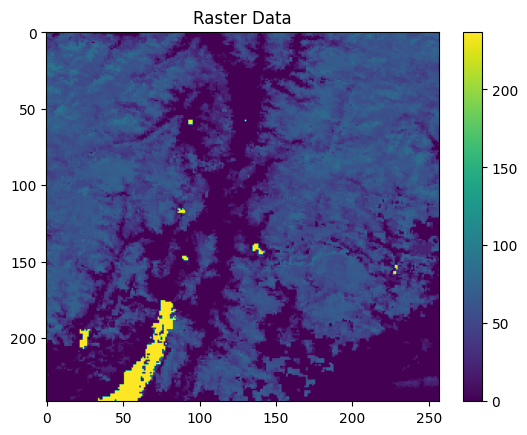

In [41]:
## Check out saved raster data
tif_file = '../data/MODIS/MOD10A1F.A2023025.h18v04.061.2023027052332.CGF_NDSI_Snow_Cover.tif'
with rasterio.open(tif_file) as src:
    data = src.read(1)  

    # Get metadata
    crs = src.crs  
    transform = src.transform  
    width = src.width  
    height = src.height  
    bounds = src.bounds  
    
    print(f"CRS: {crs}")
    print(f"Transform: {transform}")
    print(f"Width, Height: {width}, {height}")
    print(f"Bounds: {bounds}")

print(f"Data shape: {data.shape}")

# Plot
plt.imshow(data, cmap='viridis')
plt.colorbar()
plt.title("Raster Data")
plt.show()

In [ ]:
## Check out the downloaded granule (hdf)
hdf = SD('../data/MODIS/testing_parallel/MOD10A1F.A2022341.h18v04.061.2022351163911.hdf', SDC.READ)
dss = hdf.datasets()
ds = hdf.select('CGF_NDSI_Snow_Cover')
data = ds.get()

plt.figure(figsize=(8, 8))
plt.imshow(data, cmap="viridis")  
plt.colorbar(label="Value")
plt.title(f"Cropped Dataset ({'CGF_NDSI_Snow_Cover'})")
plt.xlabel("Column Index")
plt.ylabel("Row Index")
plt.show()

In [ ]:
## Example of granule preprocessing for a local file
local_file = '../data/MODIS/MOD10A1F.A2022340.h18v04.061.2022351140722.hdf'
hdf = SD(local_file, SDC.READ)
process_granule(hdf)

In [ ]:
## Example of cropping data for a single dataset (loading from local file)
local_file = '../data/MODIS/MOD10A1F.A2022340.h18v04.061.2022351140722.hdf'
hdf = SD(local_file, SDC.READ)
dataset_name = 'CGF_NDSI_Snow_Cover'
test_dataset = hdf.select(dataset_name)
studyarea_bbox_4326 = [10.46750857, 45.69873184, 11.94937569, 46.53633029]
granule_bbox_sinu, res_x, res_y, dim_x, dim_y = geo_metadata(hdf)
cropped_data = extract_study_area(hdf, dataset_name, studyarea_bbox_4326, granule_bbox_sinu, res_x, res_y)

print("\n DATASET ATTRIBUTES FOR PLOT INTERPRETATION:")
print(test_dataset.attributes()['Key']) 

# Plot the cropped data
plt.figure(figsize=(8, 8))
plt.imshow(cropped_data, cmap="viridis")  
plt.colorbar(label="Value")
plt.title(f"Cropped Dataset ({dataset_name})")
plt.xlabel("Column Index")
plt.ylabel("Row Index")
plt.show()
